In [209]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
import numpy as np
from tqdm import tqdm
from mug_cakes import bo, gp, kernel
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from mug_cakes import utils

In [211]:
# pick parameters for GP
s2f = 15
scale = 0.05
s2e = 1 ** 2 
x_true = np.array([s2f, scale, s2e])
J = 2
var_b = 5 ** 2

In [212]:
# def closure():
#     eps = 0.000001
#     xa = (res.x + 1).copy()
#     xb = xa.copy()
#     xb[1] += eps
#     est = (bo._hp_target(xb, X, Y, 2, B, var_b) - bo._hp_target(xa, X, Y, 2, B, var_b)) / eps
#     print(bo._dhp_target(xa, X, Y, 2, B, var_b))
#     print(est)
#     # N = X.shape[0]
#     # log_s2f, log_scale, log_s2e = x0
#     # s2f = np.exp(log_s2f)
#     # scale = np.exp(log_scale)
#     # s2e = np.exp(log_s2e)
#     # K = kernel.rbf(X, X, scale, s2f)
#     # vara = bo.full_cov(K[None], 2, s2e, 1)[0, :N, :N]
#     # varb = bo.full_cov(K[None], 2, s2e + eps, 1)[0, :N, :N]
#     # print((varb - vara)/eps)
#     # print(bo.full_cov(np.zeros((N,N)), 2, 1, 0)[0, :N, :N])
# closure()

In [219]:
%%time
N = 20 * J
P = 50
bounds = ((-1, 4), (-7, 4), (-7, 4))
# running_sum = 0
# for _ in tqdm(range(P)):
#     x_0 = np.array([0, 0, 0])
#     X = np.linspace(0,1, N // J).reshape(-1, 1)
#     X = utils.rowpeat(X, 2)
#     K = kernel.rbf(X, X, scale, s2f)
#     var = bo.full_cov(K, 2, s2e, var_b)
#     Y = stats.multivariate_normal.rvs(cov = var)[:N]
#     res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,2,var_b), bounds=bounds)
#     running_sum += np.exp(res.x)
# print(running_sum / P, x_true)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


In [313]:
N = 10 * J

# sample data
X = np.linspace(0,1, N // J).reshape(-1, 1)
X = np.random.rand(N, 1)
B = np.zeros(N, dtype=np.uint64)
B[:N // 2] = 1
X[:N // 2] -= 0.5
# X = utils.rowpeat(X, J)
K = kernel.rbf(X, X, scale, s2f)
var = bo.full_cov(K, J, B, s2e, var_b)
Y = stats.multivariate_normal.rvs(cov = var)[:N]
# Y *= 0
# Y[::2] =3
# Y[1::2] =-3

# fit hyperparameters
x0 = np.array([0, 0, 0])
# res = scipy.optimize.minimize(target, x0, method='L-BFGS-B', jac=dtarget, options={'disp': False}, args = (X,Y,J,var_b), bounds=bounds)


[10.27198629  0.07103465  0.64786374]


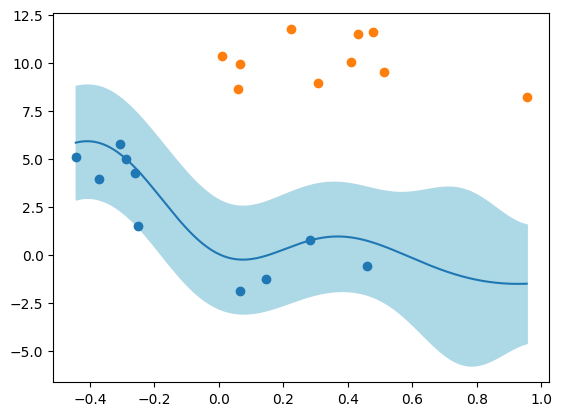

In [311]:
hparams_mle = bo.optimize_rbf_params(X, Y, J, B, var_b)
# hparams_mle[0] = 100
N_star = 1000
X_star = np.linspace(X.min(), X.max(), N_star).reshape(-1, 1)
K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
var = bo.full_cov(K, J, B, hparams_mle[2], var_b)[:N, :N]
K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
post_mean2 = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
post_var2 = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)
print(hparams_mle)

plt.fill_between(X_star.reshape(-1), post_mean2 - post_var2, post_mean2 + post_var2, color="lightblue")
plt.scatter(X[B == 1], Y[B == 1])
plt.scatter(X[B == 0], Y[B == 0])
plt.plot(X_star, post_mean2);

[8.32286401e+00 2.52034036e-03 4.05051154e-01]


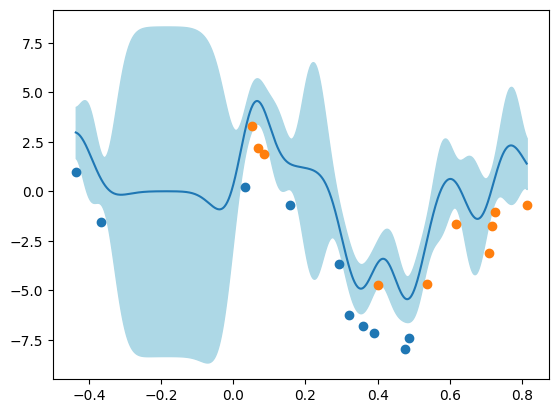

In [224]:
B1 = np.zeros_like(Y, dtype=np.uint64)

hparams_mle = bo.optimize_rbf_params(X, Y, J, B1, var_b)
X_star = np.linspace(X.min(), X.max(), N_star).reshape(-1, 1)
K = kernel.rbf(X, X, hparams_mle[1], hparams_mle[0])
var = bo.full_cov(K, 1, B1, hparams_mle[2], var_b)[:N, :N]
K_star = kernel.rbf(X, X_star, hparams_mle[1], hparams_mle[0])
K_2star = kernel.rbf(X_star, X_star, hparams_mle[1], hparams_mle[0])
post_mean = gp.conditional_mean(Y, np.linalg.inv(var), K_star.T)
post_var = gp.conditional_var(K_2star, np.linalg.inv(var), K_star.T)
print(hparams_mle)

plt.fill_between(X_star.reshape(-1), post_mean - post_var, post_mean + post_var, color="lightblue")
plt.scatter(X[B == 1], Y[B == 1])
plt.scatter(X[B == 0], Y[B == 0])
plt.plot(X_star, post_mean);

In [424]:
x_s = np.array([2])
x_M = np.array([0.1])
eps = 0.000001
kwargs = {"gamma": 0, "lambda_": 0}
(bo.expected_diff(x_s + eps, x_M, X, Y, np.linalg.inv(var[:N, :N]), scale, s2f, **kwargs)
 - bo.expected_diff(x_s, x_M, X, Y, np.linalg.inv(var[:N, :N]), scale, s2f, **kwargs))/eps

0.0008993814581970128

In [425]:
bo.dexpected_diff(x_s + eps, x_M, X, Y, np.linalg.inv(var[:N, :N]), scale, s2f, **kwargs)

0.0008993726610517347

In [433]:
x = np.array([0.1, 0.8, 0.3, .9])

In [435]:
np.exp(np.tril(np.ones((4,4))) @ np.log(x))


array([0.1   , 0.08  , 0.024 , 0.0216])

In [431]:
np.tril(np.ones((4,4))) .shape

(4, 4)

In [473]:
x = np.random.rand(10)
x.sort()

In [474]:
from numba import jit

def r(x):
    ret = np.zeros(x.shape[0] + 1)
    ret[0] = x[0]
    s = x[0]
    for i in range(1, ret.shape[0] - 1):
        ret[i] = x[i] * (1 - s)
        s += ret[i]
    ret[-1] = 1 - s
    return ret

r_fast = jit(nopython=True)(r)

In [475]:
from numba import jit

In [476]:
%%timeit
r(x)

4.61 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [477]:
%%timeit
r_fast(x)

831 ns ± 36.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
